<h1 style="font-family: Georgia; font-size:3em;color:#2462C0; font-style:bold">
K-means Clustering: Algorithm, Applications, Evaluation Methods, and Drawbacks
</h1><br>
<p align='center'>
<img src='images/kmeans.png' style='width: 700px; height:500px'>
</p>

**Overview**
- [Clustering](#introduction)
- [Kmeans Algorithm](#kmeans)
- [Implementation](#implementation)
- [Applications](#application)
    - [Geyser's Eruptions Segmentation](#2dexample)
    - [Image Compression](#imagecompression)
- [Evaluation Methods](#evaluation)
- [Drawbacks](#drawbacks)
- [Conclusion](#conclusion)

<a id='introduction'></a>
<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Clustering
</h2><br>
**Clustering** is one of the most common exploratory data analysis technique used to get an intuition about the structure of the data. It can be defined as the task of identifying subgroups in the data such that data points in the same subgroup (cluster) are very similar while data points in different clusters are very different. In other words, we try to find homogeneous subgroups within the data such that data points in each cluster are as similar as possible according to a similarity measure such as euclidean-based distance or correlation-based distance. The decision of which similarity measure to use is application-specific.

Clustering analysis can be done on the basis of features where we try to find subgroups of samples based on features or on the basis of samples where we try to find subgroups of features based on samples. We'll cover here clustering based on features. Clustering is used in market segmentation; where we try to fined customers that are similar to each other whether in terms of behaviors or attributes, image segmentation/compression; where we try to group similar regions together, document clustering based on topics, etc.

Unlike supervised learning, clustering is considered an unsupervised learning method since we don't have the ground truth to compare the output of the clustering algorithm to the true labels to evaluate its performance. We only want to try to investigate the structure of the data by grouping the data points into distinct subgroups.

In this notebook, we will cover only **Kmeans** which is considered as one of the most used clustering algorithms due to its simplicity.

<a id='kmeans'></a>
<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Kmeans Algorithm
</h2><br>
**Kmeans** algorithm is an iterative algorithm that tries to partition the dataset into $K$ pre-defined distinct non-overlapping subgroups (clusters) where each data point belongs to **only one group**. It tries to make the inter-cluster data points as similar as possible while also keeping
the clusters as different (far) as possible. It assigns data points to a cluster such that the sum of the squared distance between the data points and the cluster's centroid (arithmetic mean of all the data points that belong to that cluster) is at the minimum. The less variation we have within clusters, the more homogeneous (similar) the data points are within the same cluster.

The way kmeans algorithm works is as follows:
1. Specify number of clusters $K$.
2. Initialize centroids by first shuffling the dataset and then randomly selecting $K$ data points for the centroids without replacement.
3. Keep iterating until there is no change to the centroids. i.e assignment of data points to clusters isn't changing.
    - Compute the sum of the squared distance between data points and all centroids.
    - Assign each data point to the closest cluster (centroid).
    - Compute the centroids for the clusters by taking the average of the all data points that belong to each cluster.

The approach kmeans follows to solve the problem is called **Expectation-Maximization**. The E-step is assigning the data points to the closest cluster. The M-step is computing the centroid of each cluster. Below is a break down of how we can solve it mathematically (feel free to skip it).

The objective function is:
$$J = \sum_{i = 1}^{m}\sum_{k = 1}^{K}w_{ik}\|x^i - \mu_k\|^2\\{}$$
where $w_{ik} = 1$ for data point $x^i$ if it belongs to cluster $k$; otherwise, $w_{ik} = 0$. Also, $\mu_k$ is the centroid of $x^i$'s cluster.

It's a minimization problem of two parts. We first minimize J w.r.t. $w_{ik}$ and treat $\mu_k$ fixed. Then we minimize J w.r.t. $\mu_k$ and treat $w_{ik}$ fixed. Technically speaking, we differentiate J w.r.t. $w_{ik}$ first and update cluster assignments  (*E-step*). Then we differentiate J w.r.t. $\mu_{k}$ and recompute the centroids after the cluster assignments from previous step  (*M-step*). Therefore, E-step is:
$$\frac{\partial J}{\partial w_{ik}} = \sum_{i = 1}^{m}\sum_{k = 1}^{K}\|x^i - \mu_k\|^2\\{}$$
$$
\Rightarrow
\begin{equation}
  w_{ik} = \begin{cases}
    1 & \text{if $k = arg min_j\ \|x^i - \mu_j\|^2$}\\
    0 & \text{otherwise}.
  \end{cases}
\end{equation}\tag{1}\\{}
$$
In other words, assign the data point $x^i$ to the closest cluster judged by its sum of squared distance from cluster's centroid.

And M-step is:
$$\ \frac{\partial J}{\partial \mu_k} = 2\sum_{i = 1}^{m}w_{ik}(x^i - \mu_k) = 0\\{}$$
$$\Rightarrow \mu_k = \frac{\sum_{i = 1}^{m}w_{ik}x^i}{\sum_{i = 1}^{m}w_{ik}}\tag{2}\\{}$$
Which translates to recomputing the centroid of each cluster to reflect the new assignments.

Few things to note here:
- Since clustering algorithms including kmeans use distance-based measurements to determine the similarity between data points, it's recommended to standardize the data to have a mean of zero and a standard deviation of one since almost always the features in any dataset would have different units of measurements such as age vs income.
- Given kmeans iterative nature and the random initialization of centroids at the start of the algorithm, different initializations may lead to different clusters since kmeans algorithm may *stuck in a local optimum and may not converge to global optimum*. Therefore, it's recommended to run the algorithm using different initializations of centroids and pick the results of the run that that yielded the lower sum of squared distance.
- Assignment of examples isn't changing is the same thing as no change in within-cluster variation:
$$\frac{1}{m_k}\sum_{i = 1}^{m_k}\|x^i - \mu_{c^k}\|^2$$

<a id='implementation'></a>
<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Implementation
</h2><br>
We'll use simple implementation of kmeans here to just illustrate some concepts. Then we will use `sklearn` implementation that is more efficient take care of many things for us.

In [1]:
import numpy as np
from numpy.linalg import norm


class Kmeans:
    '''Implementing Kmeans algorithm.'''

    def __init__(self, n_clusters, max_iter=100, random_state=123):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state

    def initializ_centroids(self, X):
        np.random.RandomState(self.random_state)
        random_idx = np.random.permutation(X.shape[0])
        centroids = X[random_idx[:self.n_clusters]]
        return centroids

    def compute_centroids(self, X, labels):
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            centroids[k, :] = np.mean(X[labels == k, :], axis=0)
        return centroids

    def compute_distance(self, X, centroids):
        distance = np.zeros((X.shape[0], self.n_clusters))
        for k in range(self.n_clusters):
            row_norm = norm(X - centroids[k, :], axis=1)
            distance[:, k] = np.square(row_norm)
        return distance

    def find_closest_cluster(self, distance):
        return np.argmin(distance, axis=1)

    def compute_sse(self, X, labels, centroids):
        distance = np.zeros(X.shape[0])
        for k in range(self.n_clusters):
            distance[labels == k] = norm(X[labels == k] - centroids[k], axis=1)
        return np.sum(np.square(distance))
    
    def fit(self, X):
        self.centroids = self.initializ_centroids(X)
        for i in range(self.max_iter):
            old_centroids = self.centroids
            distance = self.compute_distance(X, old_centroids)
            self.labels = self.find_closest_cluster(distance)
            self.centroids = self.compute_centroids(X, self.labels)
            if np.all(old_centroids == self.centroids):
                break
        self.error = self.compute_sse(X, self.labels, self.centroids)
    
    def predict(self, X):
        distance = self.compute_distance(X, old_centroids)
        return self.find_closest_cluster(distance)

<a id='application'></a>
<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Applications
</h2><br>
kmeans algorithm is very popular and used in a variety of applications such as market segmentation, document clustering, image segmentation and image compression, etc. The goal usually when we undergo a cluster analysis is either:
1. Get a meaningful intuition of the structure of the data we're dealing with.
2. Cluster-then-predict where different models will be built for different subgroups if we believe there is a wide variation in the behaviors of different subgroups. An example of that is clustering patients into different subgroups and build a model for each subgroup to predict the probability of the risk of having heart attack.

In this notebook, we'll apply clustering on two cases:
- Geyser eruptions segmentation (2-D dataset).
- Image compression.

<a id='2dexample'></a>
<h2 style="font-family: Georgia; font-size:1.5em;color:purple; font-style:bold">
Kmeans on Geyser's Eruptions Segmentation
</h2><br>
We'll first implement the kmeans algorithm on 2D dataset and see how it works. The dataset has 272 observations and 2 features. The data covers the waiting time between eruptions and the duration of the eruption for the Old Faithful geyser in Yellowstone National Park, Wyoming, USA. We will try to find $K$ subgroups within the data points and group them accordingly. Below is the description of the features:
- eruptions (float): Eruption time in minutes.
- waiting (int):  Waiting time to next eruption.

Let's plot the data first:

In [2]:
# Modules
import matplotlib.pyplot as plt
from matplotlib.image import imread
import pandas as pd
import seaborn as sns
from sklearn.datasets.samples_generator import (make_blobs,
                                                make_circles,
                                                make_moons)
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score

%matplotlib inline
sns.set_context('notebook')
plt.style.use('fivethirtyeight')
from warnings import filterwarnings
filterwarnings('ignore')

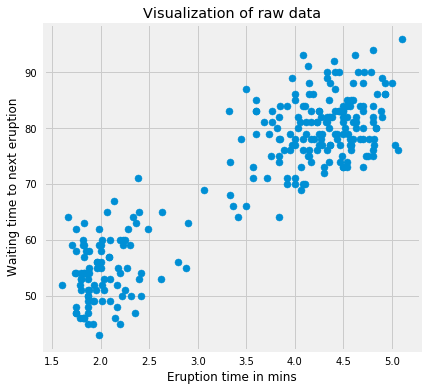

In [3]:
# Import the data
df = pd.read_csv('../data/old_faithful.csv')

# Plot the data
plt.figure(figsize=(6, 6))
plt.scatter(df.iloc[:, 0], df.iloc[:, 1])
plt.xlabel('Eruption time in mins')
plt.ylabel('Waiting time to next eruption')
plt.title('Visualization of raw data');

We'll use this data because it's easy to plot and visually spot the clusters since its a 2-dimension dataset. It's obvious that we have 2 clusters. Let's standardize the data first and run the kmeans algorithm on the standardized data with $K = 2$.

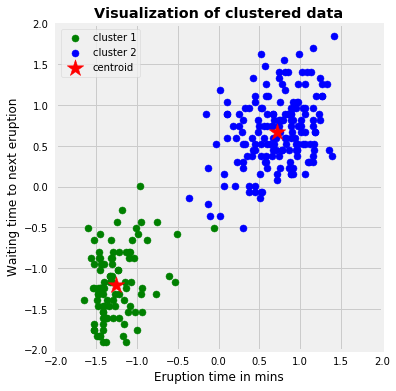

In [4]:
# Standardize the data
X_std = StandardScaler().fit_transform(df)

# Run local implementation of kmeans
km = Kmeans(n_clusters=2, max_iter=100)
km.fit(X_std)
centroids = km.centroids

# Plot the clustered data
fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(X_std[km.labels == 0, 0], X_std[km.labels == 0, 1],
            c='green', label='cluster 1')
plt.scatter(X_std[km.labels == 1, 0], X_std[km.labels == 1, 1],
            c='blue', label='cluster 2')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=300,
            c='r', label='centroid')
plt.legend()
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel('Eruption time in mins')
plt.ylabel('Waiting time to next eruption')
plt.title('Visualization of clustered data', fontweight='bold')
ax.set_aspect('equal');

The above graph shows the scatter plot of the data colored by the cluster they belong to. In this example, we chose $K = 2$. The symbol **'*'** is the centroid of each cluster. We can think of those 2 clusters as geyser had different kinds of behaviors under different scenarios.

Next, we'll show that different initializations of centroids may yield to different results. I'll use 9 different `random_state` to change the initialization of the centroids and plot the results. The title of each plot will be the sum of squared distance of each initialization.

As a side note, this dataset is considered very easy and converges in less than 10 iterations. Therefore, to see the effect of random initialization on convergence, I am going to go with 3 iterations to illustrate the concept. However, in real world applications, datasets are not at all that clean and nice!

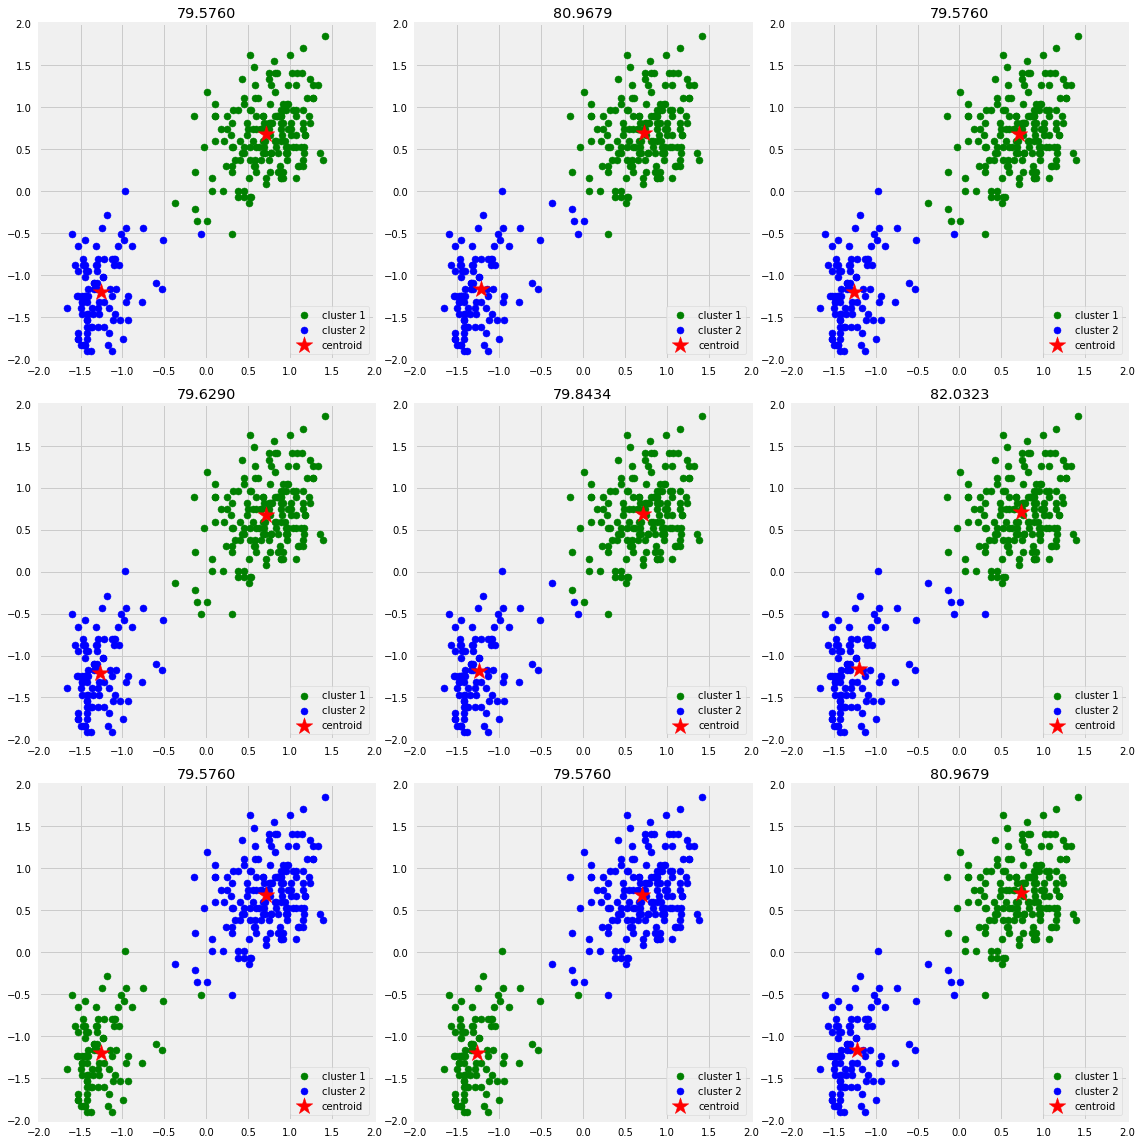

In [5]:
n_iter = 9
fig, ax = plt.subplots(3, 3, figsize=(16, 16))
ax = np.ravel(ax)
centers = []
for i in range(n_iter):
    # Run local implementation of kmeans
    km = Kmeans(n_clusters=2,
                max_iter=3,
                random_state=np.random.randint(0, 1000, size=1))
    km.fit(X_std)
    centroids = km.centroids
    centers.append(centroids)
    ax[i].scatter(X_std[km.labels == 0, 0], X_std[km.labels == 0, 1],
                  c='green', label='cluster 1')
    ax[i].scatter(X_std[km.labels == 1, 0], X_std[km.labels == 1, 1],
                  c='blue', label='cluster 2')
    ax[i].scatter(centroids[:, 0], centroids[:, 1],
                  c='r', marker='*', s=300, label='centroid')
    ax[i].set_xlim([-2, 2])
    ax[i].set_ylim([-2, 2])
    ax[i].legend(loc='lower right')
    ax[i].set_title(f'{km.error:.4f}')
    ax[i].set_aspect('equal')
plt.tight_layout();

As the graph above shows that we only ended up with two different ways of clusterings based on different initializations. We would pick the one with the lowest sum of squared distance.

<a id='imagecompression'></a>
<h2 style="font-family: Georgia; font-size:1.5em;color:purple; font-style:bold">
Kmeans on Image Compression
</h2><br>
In this part, we'll implement kmeans to compress an image. The image that we'll be working on is 396 x 396 x 3. Therefore, for each pixel location we would have 3 8-bit integers that specify the red, green, and blue intensity values. Our goal is to reduce the number of colors to 30 and represent (compress) the photo using those 30 colors only. To pick which colors to use, we'll use kmeans algorithm on the image and treat every pixel as a data point. That means reshape the image from height x width x channels to (height * width) x channel, i,e we would have 396 x 396 = 156,816 data points in 3-dimensional space which are the intensity of RGB. Doing so will allow us to represent the image using the 30 centroids for each pixel and would significantly reduce the size of the image by a factor of 6. The original image size was 396 x 396 x 24 = 3,763,584 bits; however, the new compressed image would be 30 x 24 + 396 x 396 x 4 = 627,984 bits. The huge difference comes from the fact that we'll be using centroids as a lookup for pixels' colors and that would reduce the size of each pixel location to 4-bit instead of 8-bit.

From now on we will be using `sklearn` implementation of kmeans. Few thing to note here:
- `n_init` is the number of times of running the kmeans with different centroid's initialization. The result of the best one will be reported.
- `tol` is the within-cluster variation metric used to declare convergence.
- The default of `init` is **k-means++** which is supposed to yield a better results than just random initialization of centroids.

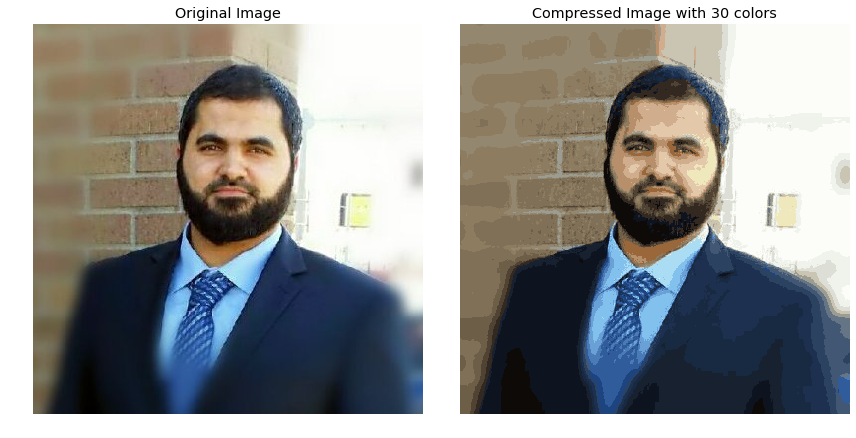

In [6]:
# Read the image
img = imread('images/my_image.jpg')
img_size = img.shape

# Reshape it to be 2-dimension
X = img.reshape(img_size[0] * img_size[1], img_size[2])

# Run the Kmeans algorithm
km = KMeans(n_clusters=30)
km.fit(X)

# Use the centroids to compress the image
X_compressed = km.cluster_centers_[km.labels_]
X_compressed = np.clip(X_compressed.astype('uint8'), 0, 255)

# Reshape X_recovered to have the same dimension as the original image 128 * 128 * 3
X_compressed = X_compressed.reshape(img_size[0], img_size[1], img_size[2])

# Plot the original and the compressed image next to each other
fig, ax = plt.subplots(1, 2, figsize = (12, 8))
ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[1].imshow(X_compressed)
ax[1].set_title('Compressed Image with 30 colors')
for ax in fig.axes:
    ax.axis('off')
plt.tight_layout();

We can see the comparison between the original image and the compressed one. The compressed image looks close to the original one which means we're able to retain the majority of the characteristics of the original image. With smaller number of clusters we would have higher compression rate at the expense of image quality. As a side note, this image compression method is called *lossy data compression* because we can't reconstruct the original image from the compressed image.

<a id='evaluation'></a>
<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Evaluation Methods
</h2><br>
Contrary to supervised learning where we have the ground truth to evaluate the model's performance, clustering analysis doesn't have a solid evaluation metric that we can use to evaluate the outcome of different clustering algorithms. Moreover, since kmeans requires $k$ as an input and doesn't learn it from data, there is no right answer in terms of the number of clusters that we should have in any problem. Sometimes domain knowledge and intuition may help but usually that is not the case. In the cluster-predict methodology, we can evaluate how well the models are performing based on different $K$ clusters since clusters are used in the downstream modeling.

In this notebook we'll cover two metrics that may give us some intuition about $k$:
- Elbow method
- Silhouette analysis

<a id='elbow'></a>
<h2 style="font-family: Georgia; font-size:1.5em;color:purple; font-style:bold">
Elbow Method
</h2><br>
**Elbow** method gives us an idea on what a good $k$ number of clusters would be based on the sum of squared distance (SSE) between data points and their assigned clusters' centroids. We pick $k$ at the spot where SSE starts to flatten out and forming an elbow. We'll use the geyser dataset and evaluate SSE for different values of $k$ and see where the curve might form an elbow and flatten out.

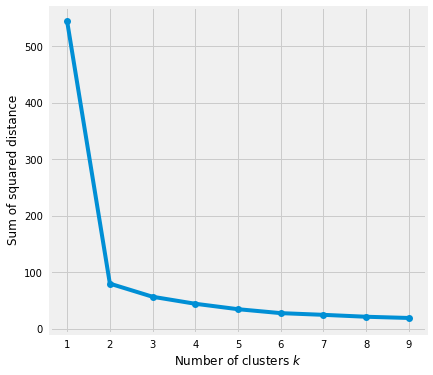

In [7]:
# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_std)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters $k$')
plt.ylabel('Sum of squared distance');

The graph above shows that $k = 2$ is not a good choice. Sometimes it's still hard to figure out a good number of clusters to use because the curve is monotonically decreasing and may not show any elbow or has an obvious point where the curve starts flattening out.

<a id='silhouette'></a>
<h2 style="font-family: Georgia; font-size:1.5em;color:purple; font-style:bold">
Silhouette Analysis
</h2><br>
**Silhouette analysis** can be used to determine the degree of separation between clusters. For each sample:
- Compute the average distance from all data points in the same cluster ($a^i$).
- Compute the average distance from all data points in the closest cluster ($b^i$).
- Compute the coefficient:
$$\frac{b^i - a^i}{max(a^i, b^i)}$$
The coefficient can take values in the interval [-1, 1].
- If it is 0 --> the sample is very close to the neighboring clusters.
- It it is 1 --> the sample is far away from the neighboring clusters.
- It it is -1 --> the sample is assigned to the wrong clusters.

Therefore, we want the coefficients to be as big as possible and close to 1 to have a good clusters. We'll use here geyser dataset again because its cheaper to run the silhouette analysis and it is actually obvious that there is most likely only two groups of data points.

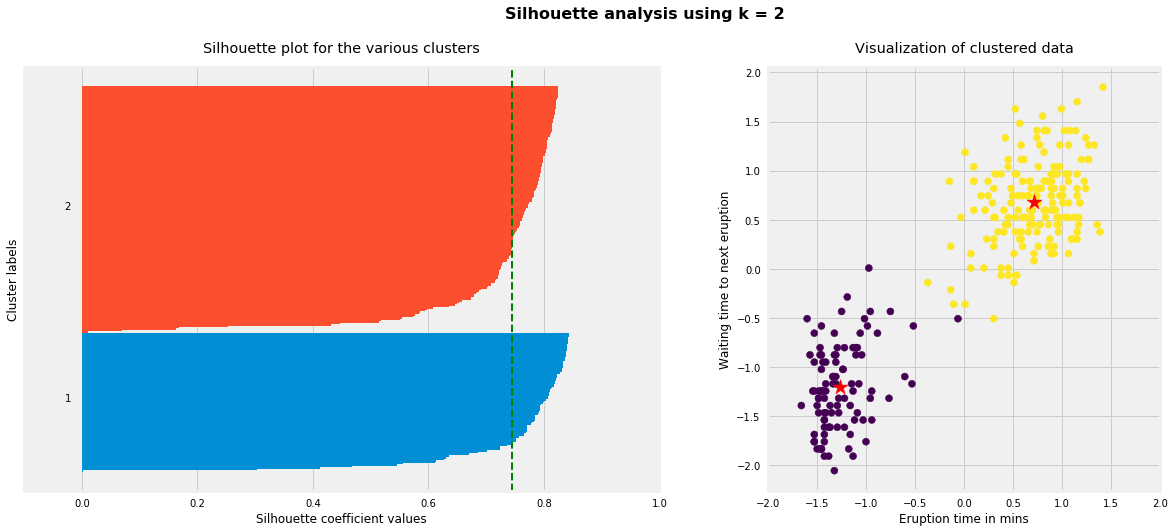

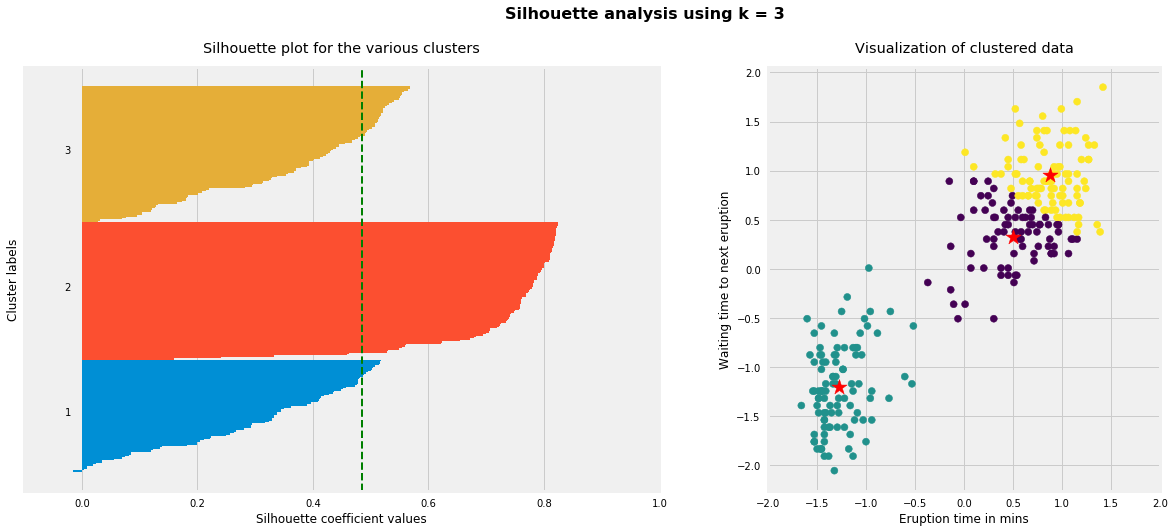

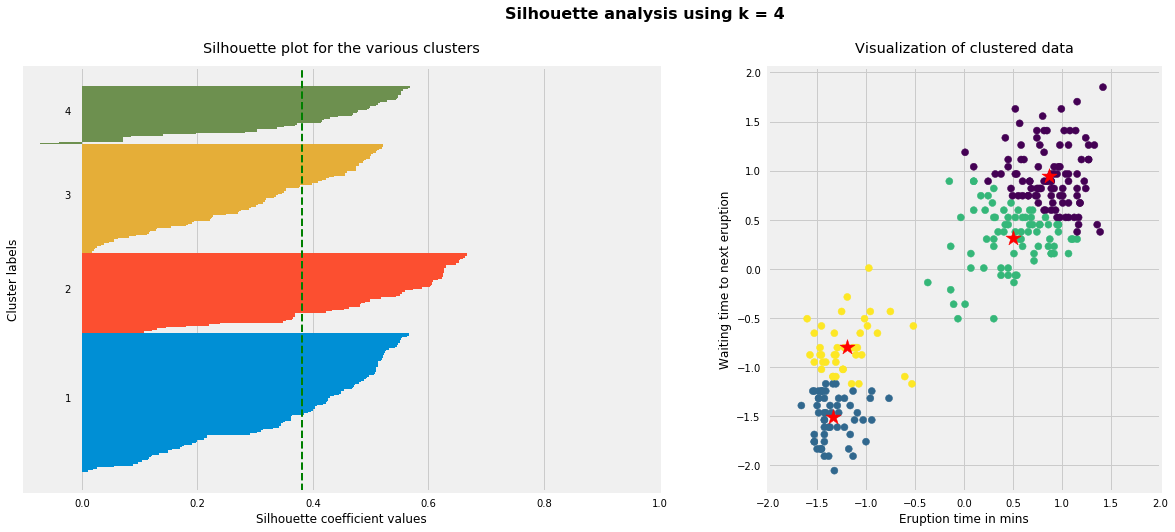

In [8]:
for i, k in enumerate([2, 3, 4]):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(X_std)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(X_std, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    
    # Scatter plot of data colored with labels
    ax2.scatter(X_std[:, 0], X_std[:, 1], c=labels)
    ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    ax2.set_xlim([-2, 2])
    ax2.set_xlim([-2, 2])
    ax2.set_xlabel('Eruption time in mins')
    ax2.set_ylabel('Waiting time to next eruption')
    ax2.set_title('Visualization of clustered data', y=1.02)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);

As the above plots show, `n_clusters=2` has the best average silhouette score of around 0.75 and all clusters being above the average shows that it is actually a good choice. Also, the thickness of the silhouette plot gives an indication of how big each cluster is. The plot shows that cluster 1 has almost double the samples than cluster 2. However, as we increased `n_clusters` to 3 and 4, the average silhouette score decreased dramatically to around 0.48 and 0.39 respectively. Moreover, the thickness of silhouette plot started showing wide fluctuations. The bottom line is: Good `n_clusters` will have a well above 0.5 silhouette average score as well as all of the clusters have higher than the average score.

<a id='drawbacks'></a>
<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Drawbacks
</h2><br>
Kmeans algorithm is good in capturing structure of the data if clusters have a spherical-like shape. It always try to construct a nice spherical shape around the centroid. That means, the minute the clusters have a complicated geometric shapes, kmeans does a poor job in clustering the data. We'll illustrate three cases where kmeans will not perform well.

First, kmeans algorithm doesn't let data points that are far-away from each other share the same cluster even though they obviously belong to the same cluster. Below is an example of data points on two different horizontal lines that illustrates how kmeans tries to group half of the data points of each horizontal lines together. 

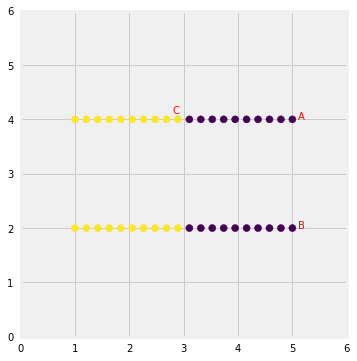

In [9]:
# Create horizantal data
X = np.tile(np.linspace(1, 5, 20), 2)
y = np.repeat(np.array([2, 4]), 20)
df = np.c_[X, y]

km = KMeans(n_clusters=2)
km.fit(df)
labels = km.predict(df)
centroids = km.cluster_centers_

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(X, y, c=labels)
plt.xlim([0, 6])
plt.ylim([0, 6])
plt.text(5.1, 4, 'A', color='red')
plt.text(5.1, 2, 'B', color='red')
plt.text(2.8, 4.1, 'C', color='red')
ax.set_aspect('equal')

Kmeans considers the point 'B' closer to point 'A' than point 'C' since they have non-spherical shape. Therefore, points 'A' and 'B' will be in the same cluster but point 'C' will be in a different cluster. Note the **Single Linkage** hierarchical clustering method gets this right because it doesn't separate similar points).

Second, we'll generate data from multivariate normal distributions with different means and standard deviations. So we would have 3 groups of data where each group was generated from different multivariate normal distribution (different mean/standard deviation). One group will have a lot more data points than the other two combined. Next, we'll run kmeans on the data with $K = 3$ and see if it will be able to cluster the data correctly. To make the comparison easier, I am going to plot first the data colored based on the distribution it came from. Then I will plot the same data but now colored based on the clusters they have been assigned to.

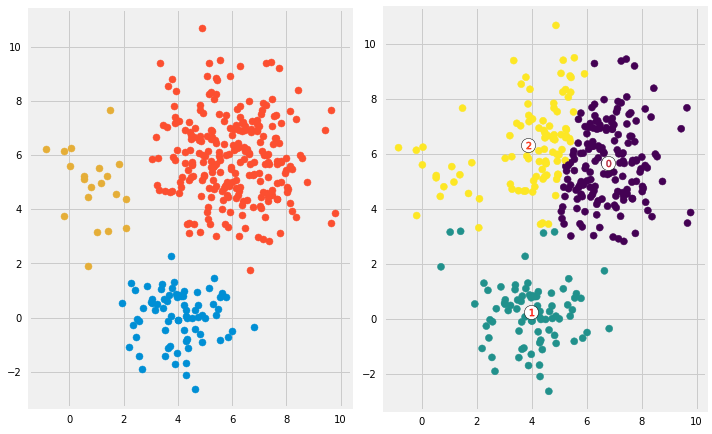

In [10]:
# Create data from three different multivariate distributions
X_1 = np.random.multivariate_normal(mean=[4, 0], cov=[[1, 0], [0, 1]], size=75)
X_2 = np.random.multivariate_normal(mean=[6, 6], cov=[[2, 0], [0, 2]], size=250)
X_3 = np.random.multivariate_normal(mean=[1, 5], cov=[[1, 0], [0, 2]], size=20)
df = np.concatenate([X_1, X_2, X_3])

# Run kmeans
km = KMeans(n_clusters=3)
km.fit(df)
labels = km.predict(df)
centroids = km.cluster_centers_

# Plot the data
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].scatter(X_1[:, 0], X_1[:, 1])
ax[0].scatter(X_2[:, 0], X_2[:, 1])
ax[0].scatter(X_3[:, 0], X_3[:, 1])
ax[0].set_aspect('equal')
ax[1].scatter(df[:, 0], df[:, 1], c=labels)
ax[1].scatter(centroids[:, 0], centroids[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
for i, c in enumerate(centroids):
    ax[1].scatter(c[0], c[1], marker='$%d$' % i, s=50, alpha=1, edgecolor='r')
ax[1].set_aspect('equal')
plt.tight_layout()

Looks like kmeans couldn't figure out the clusters correctly. Since it tries to minimize the within-cluster variation, it gives more weight to bigger clusters than smaller ones. In other words, data points in smaller clusters may be left away from the centroid in order to focus more on the larger cluster.

Last, we'll generate data that have complicated geometric shapes such as moons and circles within each other and test kmeans on both of the datasets.

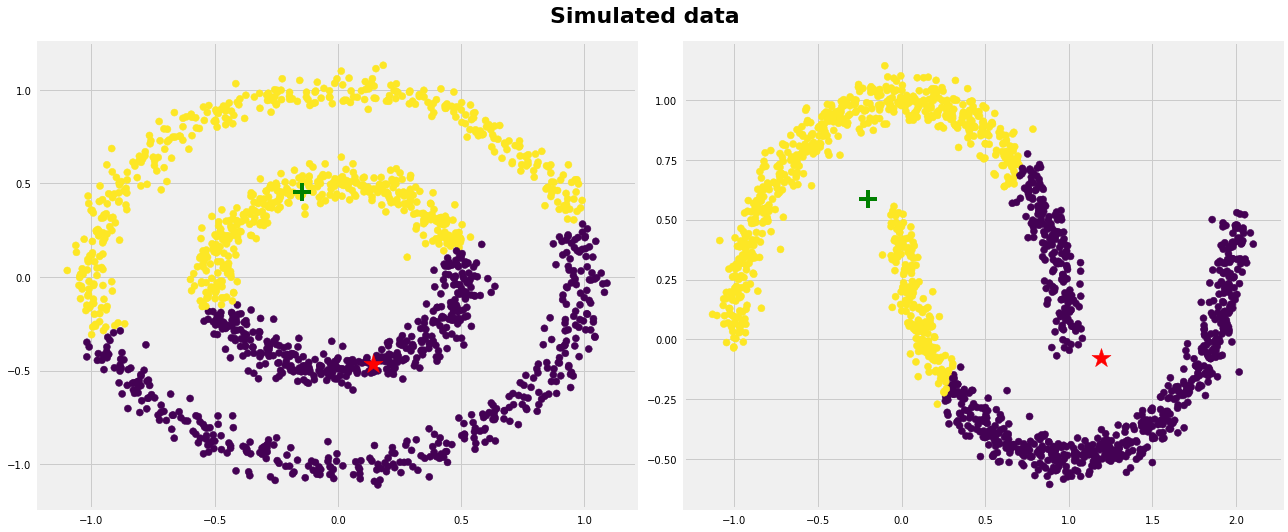

In [11]:
# Cricles
X1 = make_circles(factor=0.5, noise=0.05, n_samples=1500)

# Moons
X2 = make_moons(n_samples=1500, noise=0.05)

fig, ax = plt.subplots(1, 2)
for i, X in enumerate([X1, X2]):
    fig.set_size_inches(18, 7)
    km = KMeans(n_clusters=2)
    km.fit(X[0])
    labels = km.predict(X[0])
    centroids = km.cluster_centers_

    ax[i].scatter(X[0][:, 0], X[0][:, 1], c=labels)
    ax[i].scatter(centroids[0, 0], centroids[0, 1], marker='*', s=400, c='r')
    ax[i].scatter(centroids[1, 0], centroids[1, 1], marker='+', s=300, c='green')
plt.suptitle('Simulated data', y=1.05, fontsize=22, fontweight='semibold')
plt.tight_layout()

As expected, kmeans couldn't figure out the correct clusters for both datasets. However, we can help kmeans perfectly cluster these kind of datasets if we use kernel methods. The idea is we transform to higher dimensional representation that make the data linearly separable (the same idea that we use in SVMs). Different kinds of algorithms work very well in such scenarios such as `SpectralClustering`, see below:

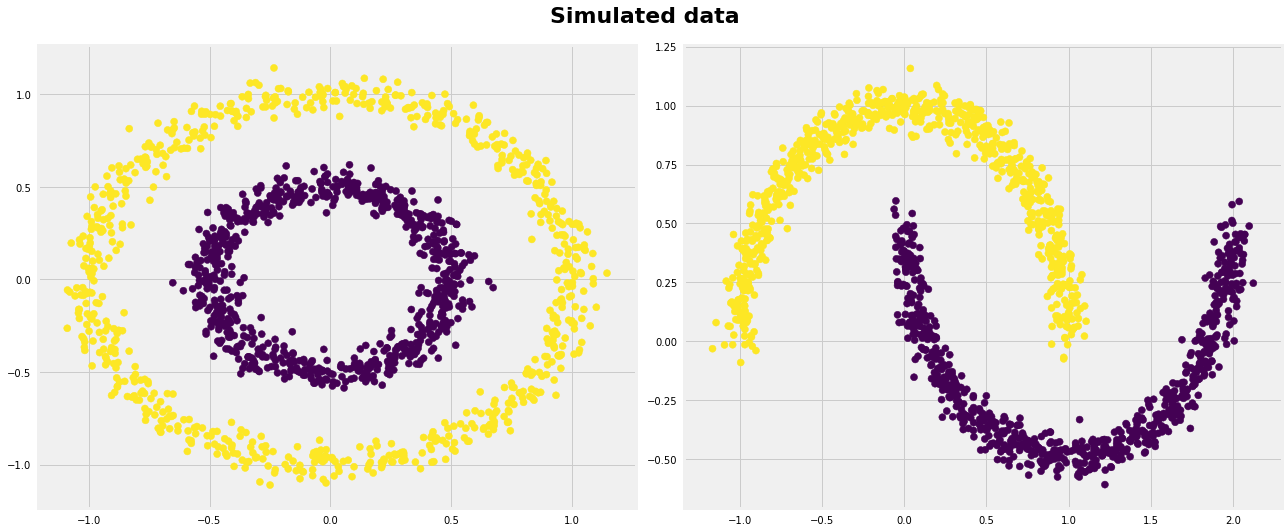

In [12]:
# Cricles
X1 = make_circles(factor=0.5, noise=0.05, n_samples=1500)

# Moons
X2 = make_moons(n_samples=1500, noise=0.05)

fig, ax = plt.subplots(1, 2)
for i, X in enumerate([X1, X2]):
    fig.set_size_inches(18, 7)
    sp = SpectralClustering(n_clusters=2, affinity='nearest_neighbors')
    sp.fit(X[0])
    labels = sp.labels_
    ax[i].scatter(X[0][:, 0], X[0][:, 1], c=labels)
plt.suptitle('Simulated data', y=1.05, fontsize=22, fontweight='semibold')
plt.tight_layout()

<a id='conclusion'></a>
<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Conclusion
</h2><br>
Kmeans clustering is one of the most popular clustering algorithms and usually the first thing practitioners apply when solving clustering tasks to get an idea of the structure of the dataset. The goal of kmeans is to group data points into distinct non-overlapping subgroups. It does a very good job when the clusters have a kind of spherical shapes. However, it suffers as the geometric shapes of clusters deviates from spherical shapes. Moreover, it also doesn't learn the number of clusters from the data and requires it to be pre-defined. To be a good practitioner, it's good to know the assumptions behind algorithms/methods so that you would have a pretty good idea about the strength and weakness of each method. This will help you decide when to use each method and under what circumstances. In this notebook, we covered both strength, weaknesses, and some evaluation methods related to kmeans.

Below are the main takeaways:
* Scale/standardize the data when applying kmeans algorithm.
* Elbow method in selecting number of clusters doesn't usually work because the error function is monotonically decreasing for all $k$s.
* Kmeans gives more weight to the bigger clusters.
* Kmeans assumes spherical shapes of clusters (with radius equal to the distance between the centroid and the furthest data point) and doesn't work well when clusters are in different shapes such as elliptical clusters.
- If there is overlapping between clusters, kmeans doesn't have an intrinsic measure for uncertainty for the examples belong to the overlapping region in order to determine for which cluster to assign each data point.
* Kmeans may still cluster the data even if it can't be clustered such as data that comes from *uniform distributions*.